# Load the heartbeats from 256205 patients to pre-train the VAE

In [1]:
#Load beats
import pandas as pd

heartbeats_I = pd.read_csv('AMC_PRETRAIN_BEAT_I.csv', index_col=[0])
heartbeats_II = pd.read_csv('AMC_PRETRAIN_BEAT_II.csv', index_col=[0])
heartbeats_V1 = pd.read_csv('AMC_PRETRAIN_BEAT_III.csv', index_col=[0])
heartbeats_V2 = pd.read_csv('AMC_PRETRAIN_BEAT_IV.csv', index_col=[0])
heartbeats_V3 = pd.read_csv('AMC_PRETRAIN_BEAT_V.csv', index_col=[0])
heartbeats_V4 = pd.read_csv('AMC_PRETRAIN_BEAT_VI.csv', index_col=[0])
heartbeats_V5 = pd.read_csv('AMC_PRETRAIN_BEAT_VII.csv', index_col=[0])
heartbeats_V6 = pd.read_csv('AMC_PRETRAIN_BEAT_VIII.csv', index_col=[0])

#Assign lead collumns
heartbeats_I['lead'] = 'I'

heartbeats_II['lead'] = 'II'

heartbeats_V1['lead'] = 'V1'
heartbeats_V1 = heartbeats_V1.rename(columns={'250': 'ID'})

heartbeats_V2['lead'] = 'V2'
heartbeats_V2 = heartbeats_V2.rename(columns={'250': 'ID'})

heartbeats_V3['lead'] = 'V3'
heartbeats_V3 = heartbeats_V3.rename(columns={'250': 'ID'})

heartbeats_V4['lead'] = 'V4'
heartbeats_V4 = heartbeats_V4.rename(columns={'250': 'ID'})

heartbeats_V5['lead'] = 'V5'
heartbeats_V5 = heartbeats_V5.rename(columns={'250': 'ID'})

heartbeats_V6['lead'] = 'V6'
heartbeats_V6 = heartbeats_V6.rename(columns={'250': 'ID'})

In [20]:
# concatenate dataframes
heartbeats = pd.concat([heartbeats_I, 
                        heartbeats_II, 
                        heartbeats_V1, 
                        heartbeats_V2, 
                        heartbeats_V3, 
                        heartbeats_V4, 
                        heartbeats_V5, 
                        heartbeats_V6])

# reset index
heartbeats = heartbeats.reset_index(drop=True)

In [28]:
df = heartbeats

# group by ID and lead and take the mean of signals
df_mean = df.groupby(['ID', 'lead']).mean()

# reset index to convert the groupby object to a dataframe
df_mean = df_mean.reset_index()

# print the resulting dataframe
print(df_mean.shape)

(2049640, 252)


In [31]:
#Fill NA
df_mean.fillna(df_mean.mean(), inplace=True)

df_mean_mis = df_mean[df_mean.isna().any(axis=1)]
df_mean_mis.shape

df= df_mean

#Make lead and ID column str
df['lead'] = df['lead'].astype(str)
df['ID'] = df['ID'].astype(int)

#Sort the df
sorted_df = df.sort_values(by=['ID', 'lead'], ascending=[True, True])

df = sorted_df

C:\Users\AppData\Local\Temp\ipykernel_21792\1705742500.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mean.fillna(df_mean.mean(), inplace=True)


In [34]:
df_matrix = df.drop(columns = ['ID', 'lead'])

# Reshape the DataFrame into a numpy array
num_ecgs = df_matrix.shape[0]
num_pt = 256205
num_signals = df_matrix.shape[1]
ecgs = df_matrix.values.reshape(num_pt, 8, num_signals)
print(ecgs.shape)

(256205, 8, 250)


# Reconstruct the other leads

In [55]:
ecgs_12l = ecgs

# Subtract lead 2 from lead 1 and insert the result as a new lead at location 2
lead1 = ecgs_12l[:, 0, :]  # Extract lead 1 data for all patients
lead2 = ecgs_12l[:, 1, :]  # Extract lead 2 data for all patients
lead3 = lead1 - lead2  # Subtract lead 2 from lead 1

ecgs_12l = np.insert(ecgs_12l, 2, lead3, axis=1)  # Insert the new lead at location 2 in the second dimension

# Reconstruct Lead AVR
lead_AVR = lead1 + lead2 - lead3
ecgs_12l = np.insert(ecgs_12l, 3, lead_AVR, axis=1)  # Insert the new lead at location 2 in the second dimension

# Reconstruct Lead AVL
lead_AVL = (lead1 + lead2) / 2 - lead3
ecgs_12l = np.insert(ecgs_12l, 4, lead_AVL, axis=1)  # Insert the new lead at location 2 in the second dimension

# Reconstruct Lead AVF
lead_AVF = (lead1 + lead2) / 2
ecgs_12l = np.insert(ecgs_12l, 5, lead_AVF, axis=1)  # Insert the new lead at location 2 in the second dimension


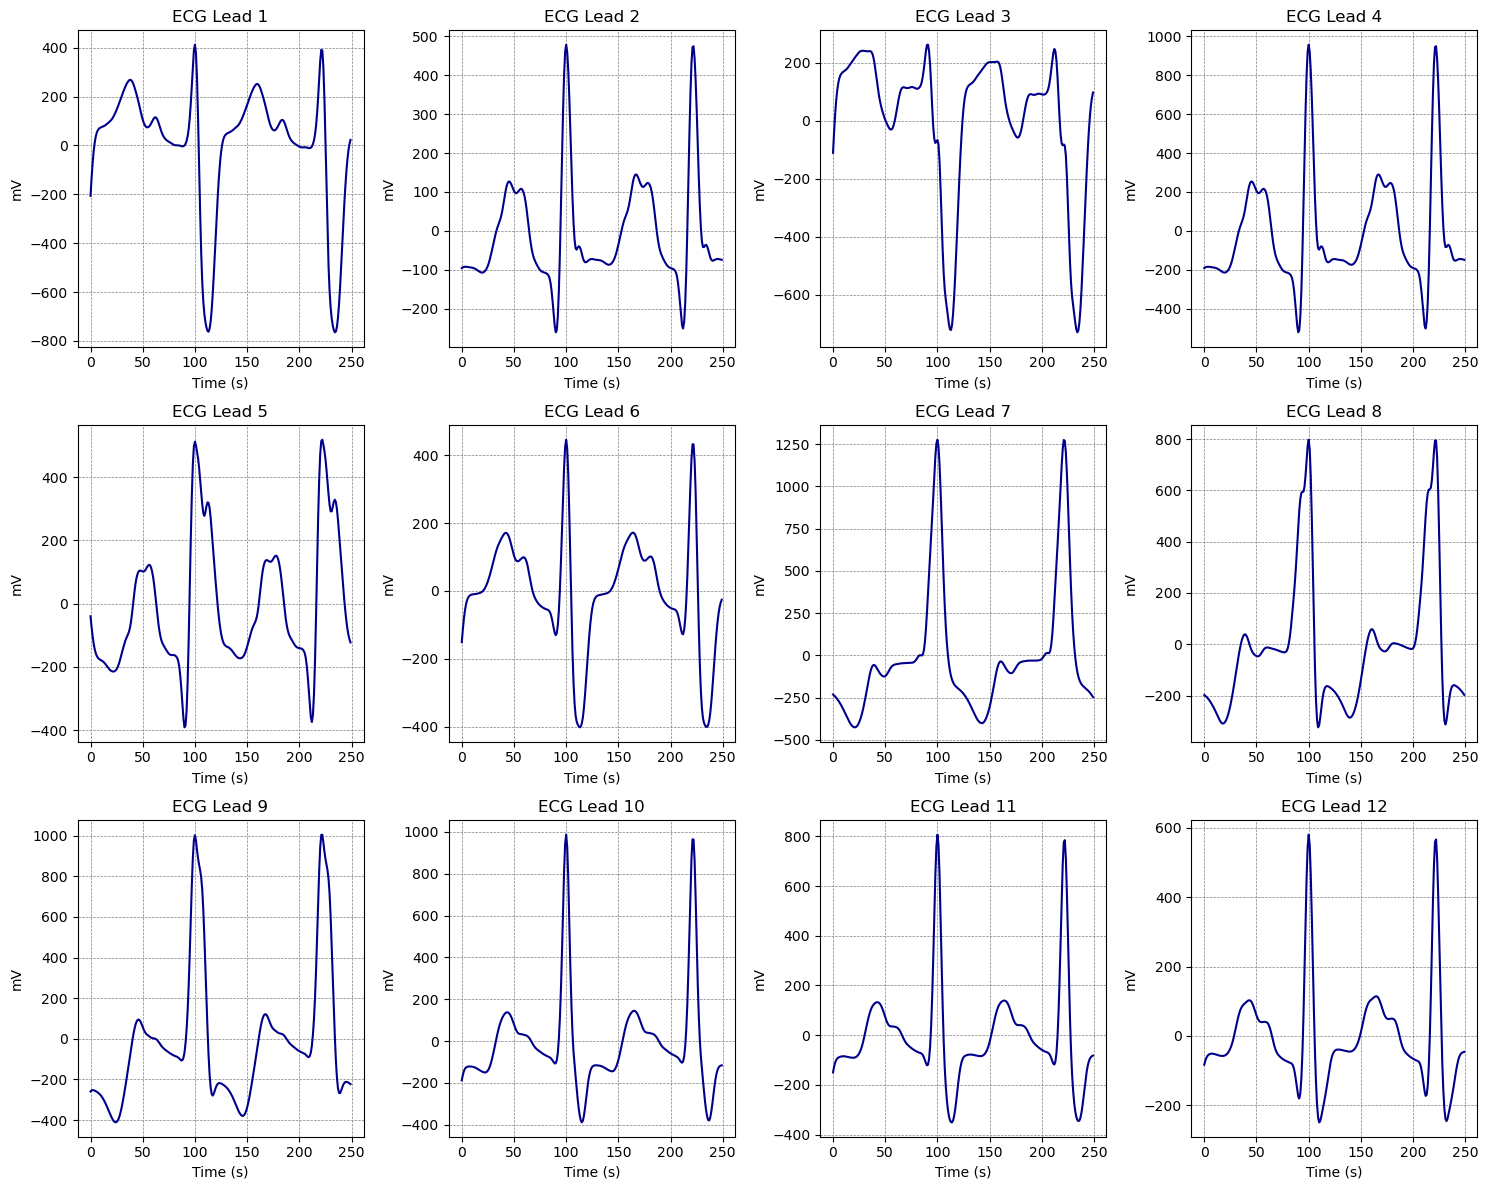

In [146]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))

for i, ax in enumerate(axes.flatten()):
    ax.plot(ecgs_12l[2, i, :], linestyle='-', color='darkblue')
    ax.grid(linewidth=0.5, color='gray', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('mV')
    ax.set_title(f'ECG Lead {i+1}')

plt.tight_layout()
plt.show()
plt.close()

# Standardise and min-max scale the signals

In [63]:
# Calculate mean and standard deviation along the third dimension
mean = np.mean(ecgs_12l, axis=(1,2), keepdims=True)
std = np.std(ecgs_12l, axis=(1,2), keepdims=True)

# Subtract mean and divide by standard deviation
arr_standardized = (ecgs_12l - mean) / std

# Normalize along the leads axis (axis=1)
arr_norm = np.linalg.norm(arr_standardized, axis=2, keepdims=True)

# Divide the standardized array by the norm to get the normalized array
ecgs_norm = arr_standardized / arr_norm

def min_max_scaler_3d(data, min_perc=5, max_perc=95):
    min_val = np.percentile(data, min_perc, axis=(1,2), keepdims=True)
    max_val = np.percentile(data, max_perc, axis=(1,2), keepdims=True)
    range_val = max_val - min_val
    scaled_data = (data - min_val) / range_val
    return scaled_data

idx_norm = min_max_scaler_3d(ecgs_norm, min_perc=.5, max_perc=99.5)

import matplotlib.pyplot as plt
x = np.arange(0, 250, 1)
fig = plt.figure(figsize=(5, 3)) 
for i in range(1, 1000, 175):
    plt.plot(idx_norm[i, 5, :], linestyle='--', label=f'Sample {i}')
#plt.legend()
plt.title("First 50 ECG normalised")
plt.show()

# Train the VAE on the pre-train dataset, save weights

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Define input layer
input_signal = Input(shape=(6, 210,))
latent_dim = 16

# Encoder layers
x = Flatten()(input_signal)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)


# Define mean and log-variance layers for latent variables
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder layers
x = Dense(64, activation='relu')(z)
x = Dense(128, activation='relu')(x)
decoded = Dense(6 * 210, activation='sigmoid')(x)
decoded = Reshape((6, 210))(decoded)

# Define VAE model
vae_model = Model(input_signal, decoded)

# Define VAE loss function
def vae_loss(input_signal, decoded):
    mse_loss = K.mean(K.square(input_signal - decoded), axis=(1,2))
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return mse_loss + kl_loss

adam = Adam(lr=0.001)
vae_model.compile(optimizer=adam, loss=vae_loss)

# Define encoder model
encoder_model = Model(input_signal, z_mean)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=1,
                               verbose=1,
                               mode='min')

# Train the VAE model
history = vae_model.fit(idx_norm_extremity, idx_norm_extremity,
                        epochs=256,
                        batch_size=512,
                        shuffle=True,
                        validation_split=0.25,
                        callbacks=[early_stopping])

# Reconstruct input signal
reconstructed_signal = vae_model.predict(idx_norm_extremity)

indices = np.random.choice(idx_norm_extremity.shape[0], 125, replace=False)
pearson_all = list()
for i, idx in enumerate(indices):
        for j in range(1, 6):
            correlation_matrix = np.corrcoef(idx_norm_extremity[i, j], reconstructed_signal[i, j], rowvar=False)
            pearson_correlation = correlation_matrix[0, 1]
            pearson_all.append(pearson_correlation)
print("Pearson mean", np.mean(pearson_all))

#Save weights
vae_model.save_weights('pretrained_autoencoder_weights.h5')
vae_model.save('vae_model.h5')
encoder_model.save_weights('pretrained_encoder_weights.h5')

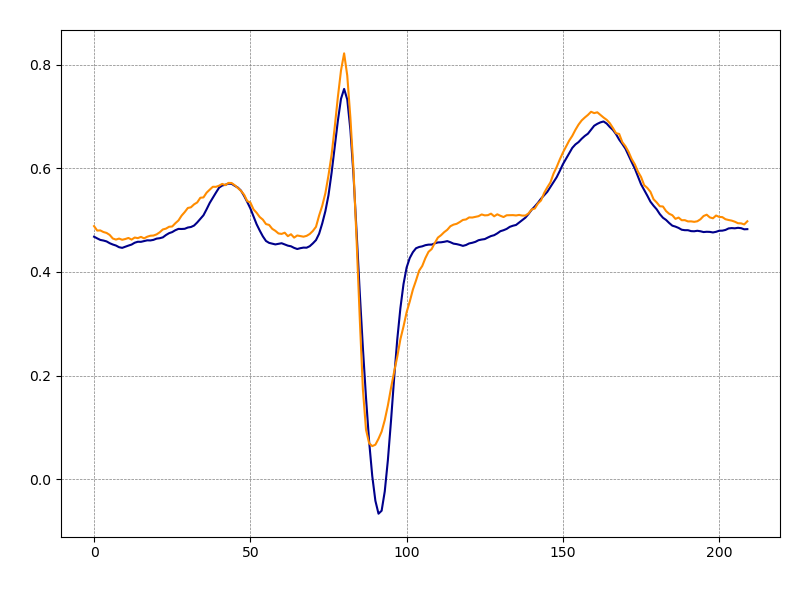

In [55]:
import matplotlib.pyplot as plt

lead_to_plot = 2  # set which lead to plot (ranges from 1 to 12)

fig, ax = plt.subplots(figsize=(8, 6))

p = 6
ax.plot(idx_norm_extremity[p, :], linestyle='-', color='darkblue')
ax.grid(linewidth=0.5, color='gray', linestyle='--')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title(' ')

ax.plot(reconstructed_signal[p, :], linestyle='-', color='darkorange')
ax.grid(linewidth=0.5, color='gray', linestyle='--')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title(' ')

plt.tight_layout()
plt.show()

plt.close()